### IMPORTS

In [90]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

pd.get_option("display.max_columns")

20

### READ DATA

In [ ]:
anon_prices = pd.read_csv("anonymized_transactions.csv")

### DATA PREP

In [5]:
anon_prices[['transaction_date', 'product_level_1', 'product_level_2', 'zproduct_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_date  999 non-null    object
 1   product_level_1   999 non-null    object
 2   product_level_2   999 non-null    object
 3   zproduct_id       999 non-null    object
dtypes: object(4)
memory usage: 31.3+ KB


In [6]:
anon_prices['transaction_month'] = pd.to_datetime(anon_prices['transaction_date']).dt.month

In [7]:
anon_prices[['transaction_month', 'product_level_1', 'product_level_2', 'zproduct_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   transaction_month  999 non-null    int64 
 1   product_level_1    999 non-null    object
 2   product_level_2    999 non-null    object
 3   zproduct_id        999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [8]:
anon_prices[ 'transaction_month'].value_counts()

3     282
1     271
12    231
2     215
Name: transaction_month, dtype: int64

In [9]:
anon_prices.describe()

,sm_transaction_0002_key,anchor_weight,test_field_2,targetpricetag,startpricetag,revenue,quantity,profit,price_unit,price_normalizer,...,lee_spend_bin,test_me_bin,snk_spend_bin,cv_split_1,target_nv,start_nv,floor_nv,cv_split_3,cv_split_2,transaction_month
count,0.0,0.0,0.0,0.0,0.0,999.000000,999.000000,999.000000,999.000000,999.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.000000
mean,NaN,NaN,NaN,NaN,NaN,2754.158627,244.094285,735.029055,11.547703,8.207517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.323323
std,NaN,NaN,NaN,NaN,NaN,5691.460171,406.173816,1524.541181,5.555201,3.790929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.277518
min,NaN,NaN,NaN,NaN,NaN,0.000000,2.000000,-4268.482000,0.000000,1.715260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,607.381150,50.000000,134.671550,7.515714,5.439222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,1369.218900,100.000000,326.965500,10.689700,7.396065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
75%,NaN,NaN,NaN,NaN,NaN,2900.379250,200.000000,824.422350,14.766741,10.336887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
max,NaN,NaN,NaN,NaN,NaN,76633.801900,4000.000000,19461.298000,69.912030,37.312920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000


In [10]:
anon_prices.head(3)

,sm_transaction_0002_key,transaction_id,anchor_weight,transaction_date,test_field_2,targetpricetag,startpricetag,revenue,region_group,quantity,...,lee_spend_bin,test_me_bin,snk_spend_bin,cv_split_1,target_nv,start_nv,floor_nv,cv_split_3,cv_split_2,transaction_month
0,NaN,2-039995466:25,NaN,2019-12-03 00:00:00.000000,NaN,NaN,NaN,2924.7128,B9,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,NaN,2-039997979:21,NaN,2019-12-05 00:00:00.000000,NaN,NaN,NaN,26427.2451,SK,3000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2,NaN,2-040000029:11,NaN,2019-12-09 00:00:00.000000,NaN,NaN,NaN,4188.5119,WLS,500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


### Data Prep: Bayesian Hierarchical Regression

In [11]:
df_params = {"hbr_b_mu": -0.25,
             "hbr_b_sig": 0.05,
             "Test_Time_Index": [12, 13],
             "Min_Elast": 0.5,
             "Max_Elast": 2.5}

hbr_b_mu = float(df_params['hbr_b_mu'])
hbr_b_sig = float(df_params['hbr_b_sig'])

anon_prices['MCMC_Partition'] = 'Global_Partition'

MCMC_Partition = np.unique(anon_prices['MCMC_Partition'])

bayes_hier = anon_prices[['MCMC_Partition',
                          'product_level_1',
                          'product_level_2',
                          'zproduct_id',
                          'transaction_month',
                          'quantity',
                          'revenue']]

bayes_tree = bayes_hier[['product_level_1',
                         'product_level_2',
                         'zproduct_id']].columns
tree_levels = len(bayes_tree)

### Metrics: Bayesian Hierarchical Regression: Statistics

In [12]:
groupby_list = ['product_level_1', 'product_level_2', 'zproduct_id', 'transaction_month']
quantity_list = ['product_level_1', 'product_level_2', 'zproduct_id', 'transaction_month', 'quantity']
revenue_list = ['product_level_1', 'product_level_2', 'zproduct_id', 'transaction_month', 'revenue']

bayes_quantity = bayes_hier[quantity_list].groupby(by=groupby_list).sum()
bayes_revenue = bayes_hier[revenue_list].groupby(by=groupby_list).sum()
bayes_avg_price = bayes_revenue['revenue'] / bayes_quantity['quantity']

bayesXmean = bayes_avg_price.mean()
bayesXstd = bayes_avg_price.std()

bayesYmean = bayes_quantity['quantity'].mean()
bayesYstd = bayes_quantity['quantity'].std()

bayesX_zscore =  (bayes_avg_price - bayesXmean) / bayesXstd
bayesY_zscore =  (bayes_quantity - bayesYmean) / bayesYstd

bayesX_zscore = bayesX_zscore.to_numpy()
bayesY_zscore = bayesY_zscore['quantity'].to_numpy()

### Metrics: Bayesian Hierarchical Regression: Levels

In [13]:
new_bayes = bayes_hier[['MCMC_Partition', 'product_level_1', 'product_level_2', 'zproduct_id']]
sort_by_list1 = ['product_level_1']
sort_by_list2 = ['product_level_1', 'product_level_2']
sort_by_list3 = ['product_level_1', 'product_level_2', 'zproduct_id']

In [14]:
# level 1
new_bayes['level1']= new_bayes.sort_values(by=sort_by_list1)\
                               .groupby(by=['MCMC_Partition'])\
                               .cumcount() + 1

# level 2
new_bayes['level2'] = new_bayes.sort_values(by=sort_by_list2)\
                               .groupby(by=['MCMC_Partition'])\
                               .cumcount() + 1

# level 3
new_bayes['level3'] = new_bayes.sort_values(by=sort_by_list3)\
                               .groupby(by=['MCMC_Partition'])\
                               .cumcount() + 1

# new_bayes['elast_segment'] = new_bayes.sort_values(by=)\
#                                .groupby(by=['MCMC_Partition'])\
#                                .cumcount() + 1

<ipython-input-14-3fe17a380076>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bayes['level1']= new_bayes.sort_values(by=sort_by_list1)\
<ipython-input-14-3fe17a380076>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bayes['level2'] = new_bayes.sort_values(by=sort_by_list2)\


In [15]:
level_1 = new_bayes['level1'].to_numpy()
level_1_unique = np.unique(level_1)
level_1_count = len(level_1_unique)

level_2 = new_bayes['level2'].to_numpy()
level_2_link = new_bayes[['level1', 'level2']].copy().drop_duplicates()['level1'].to_numpy()
level_2_unique = np.unique(level_2)
level_2_count = len(level_2_unique)

level_3 = new_bayes['level3'].to_numpy()
level_3_link = new_bayes[['level2', 'level3']].copy().drop_duplicates()['level2'].to_numpy()
level_3_unique = np.unique(level_3)
level_3_count = len(level_3_unique)

### PROGRAM

In [16]:
with pm.Model() as hierarchical_model:

    b_0 = pm.Normal(name='b_0', mu=hbr_b_mu, sigma=hbr_b_sig)

    b_1 = pm.Normal(name='b_1', mu=b_0,  sigma=hbr_b_sig, shape=level_1_count)

    b_2 = pm.Normal(name='b_2', mu=b_1[level_2_link - 1],  sigma=hbr_b_sig, shape=level_2_count)

    b_3 = pm.Normal(name='b_3', mu=b_2[level_3_link - 1],  sigma=hbr_b_sig, shape=level_3_count)

    eps = pm.HalfCauchy(name='eps', beta=1)

    # Likelihood
    Y_est = b_3[level_3[:689] - 1] * bayesX_zscore
    Y_like = pm.Normal(name='Y_like', mu=Y_est, sigma=eps, observed=bayesY_zscore)

    trace = pm.sample(draws=2000, tune=2000, cores=4, chains=2, random_seed=1, progressbar=0)

In [17]:
az.summary(data=trace, hdi_prob=0.95)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0,-0.118,0.031,-0.172,-0.058,0.010,0.007,11.0,18.0,1.17
b_1[0],-0.119,0.059,-0.234,-0.002,0.009,0.006,44.0,220.0,1.04
b_1[1],-0.117,0.057,-0.230,-0.006,0.009,0.006,42.0,318.0,1.05
b_1[2],-0.117,0.059,-0.237,-0.007,0.009,0.006,45.0,351.0,1.04
b_1[3],-0.117,0.059,-0.231,-0.000,0.008,0.006,53.0,184.0,1.03
...,...,...,...,...,...,...,...,...,...
b_3[995],-0.120,0.092,-0.299,0.061,0.009,0.006,103.0,894.0,1.02
b_3[996],-0.120,0.091,-0.297,0.056,0.007,0.005,166.0,1206.0,1.02
b_3[997],-0.119,0.092,-0.294,0.066,0.007,0.005,190.0,1658.0,1.01
b_3[998],-0.119,0.092,-0.291,0.063,0.006,0.004,251.0,1271.0,1.01


In [18]:
print(trace['posterior']['b_3'].mean(axis=1).shape)
trace

(2, 999)


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [19]:
trace['posterior']['b_3'].mean(axis=1)

<xarray.DataArray 'b_3' (chain: 2, b_3_dim_0: 999)>
array([[-0.12920171, -0.12870248, -0.12682539, ..., -0.12906995,
        -0.12855815, -0.1270994 ],
       [-0.10869975, -0.11042147, -0.10956097, ..., -0.11036843,
        -0.10910808, -0.11060258]])
Coordinates:
  * chain      (chain) int64 0 1
  * b_3_dim_0  (b_3_dim_0) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998

In [20]:
trace['posterior']['b_3'].mean(axis=1).mean(axis=1)

<xarray.DataArray 'b_3' (chain: 2)>
array([-0.12704732, -0.10800505])
Coordinates:
  * chain    (chain) int64 0 1

In [21]:
trace['posterior']['b_3'].mean(axis=1).mean(axis=1).mean(axis=0)

<xarray.DataArray 'b_3' ()>
array(-0.11752618)

In [22]:
b_est = trace['posterior']['b_3'].mean(axis=1).mean(axis=1).mean(axis=0).to_numpy()

a_est_0 = bayesYmean - ((b_est * bayesXmean * bayesYstd) / bayesXstd)
b_est_0 = (b_est * bayesYstd) / bayesXstd

y_est = a_est_0 + (b_est_0 * bayes_avg_price.to_numpy())
mape = np.mean(np.abs((y_est - bayes_quantity.to_numpy()) / bayes_quantity.to_numpy()))

## PLOT
# prediction_vs_actual_graph = np.sum(bayes_avg_price.to_numpy()) vs np.sum(bayes_quantity.to_numpy()) and np.sum(y_est)
# prediction accuracy is time index vs mape

elasticity = -1 * (b_est_0 * bayes_avg_price.to_numpy()) / (a_est_0 + b_est_0 * bayes_avg_price.to_numpy())

In [23]:
mape

3.471947525828108

In [ ]:
len(elasticity), elasticity

In [31]:
time_index = bayes_quantity.reset_index()['transaction_month']

In [86]:
elast_dict = {'elasticity': elasticity,
              'bayes_avg_price': bayes_avg_price.to_numpy(),
              'bayes_quantity': bayes_quantity.to_numpy().reshape(689),
              'y_est': y_est,
              'time index': time_index,}

mape, a_est_0, b_est_0

(3.471947525828108, 482.03143173365737, -11.13512883566523)

In [87]:
elast_df = pd.DataFrame(data=elast_dict)

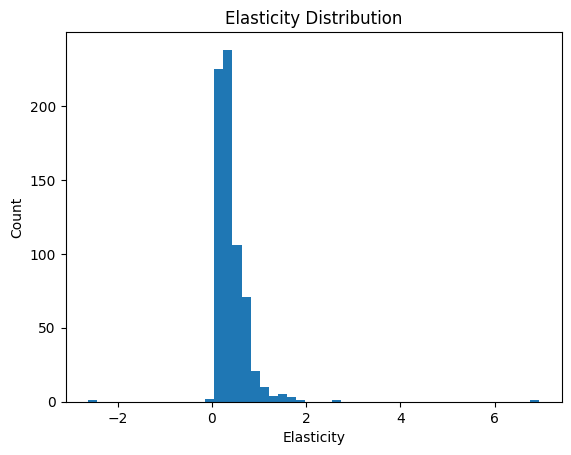

In [124]:
plt.hist(elast_dict['elasticity'], bins=50)
plt.xlabel('Elasticity')
plt.ylabel('Count')
plt.title('Elasticity Distribution')
plt.savefig('elast_distribution.png', bbox_inches='tight')

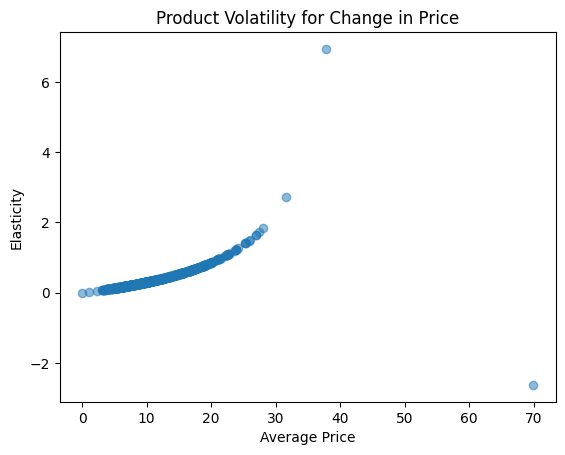

In [126]:
plt.scatter(elast_df['bayes_avg_price'], elast_df['elasticity'], alpha=0.5)
plt.xlabel('Average Price')
plt.ylabel('Elasticity')
plt.title('Product Volatility for Change in Price')
plt.savefig('price_vs_elasticity.png', bbox_inches='tight')

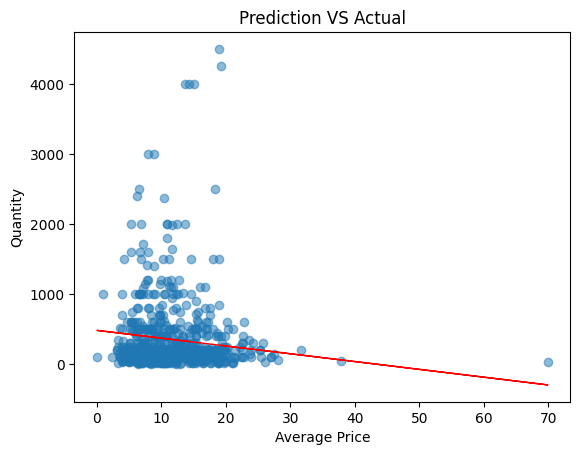

In [127]:
plt.scatter(elast_df['bayes_avg_price'], elast_df['bayes_quantity'], alpha=0.5)
plt.plot(elast_df['bayes_avg_price'], elast_df['y_est'], color='red', linewidth=1)
plt.title('Prediction VS Actual')
plt.xlabel('Average Price')
plt.ylabel('Quantity')
plt.savefig('prediction_actual.png', bbox_inches='tight')